In [1]:
import tensorflow as tf
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.Session(config=config)

/home/team4/anaconda3/envs/gpu/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/team4/anaconda3/envs/gpu/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/team4/anaconda3/envs/gpu/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/team4/anaconda3/envs/gpu/lib/python3.7/site-packages

In [15]:
import keras
import pandas as pd
import tensorflow as tf

import numpy as np
# from keras.models import Sequential, Model
# from keras.layers import Dense, Dropout, Activation, Flatten, Convolution2D, MaxPooling2D, GlobalAveragePooling2D
from keras.utils import np_utils

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Convolution2D, MaxPooling2D, GlobalAveragePooling2D, Input,AveragePooling2D, BatchNormalization, LeakyReLU, SpatialDropout2D

# from keras.applications import MobileNet
# from keras.optimizers import Adam
from tensorflow.keras.applications import MobileNetV2, InceptionV3
from tensorflow.keras.optimizers import Adam

from matplotlib import pyplot as plt
import os
from sklearn.model_selection import train_test_split

import seaborn as sns
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.model_selection import KFold

from collections import defaultdict,Counter
from imblearn.over_sampling import SMOTE
from PIL import Image

from kerastuner import HyperModel

<h2>Data Loading and Preparation</h2>

In [3]:
def getSpeciesCode(x):
    part = x.split('_')
    if part[0] == 'ASETRI':
        return 0
    elif part[0] == 'EPTBOT':
        return 1
    elif part[0] == 'MYOEMA':
        return 2
    elif part[0] == 'PIPKUH':
        return 3
    elif part[0] == 'RHIMUS':
        return 4
    elif part[0] == 'RHYNAS':
        return 5
    elif part[0] == 'ROUAEG':
        return 6
    elif part[0] == 'TAPPER':
        return 7
    else:
        return 'Unknown'
    
def getSpecies(x):
    if x == 0:
        return 'A.tridens'
    elif x == 1:
        return 'E.bottae'
    elif x == 2:
        return 'M.emarginatus'
    elif x == 3:
        return 'P.kuhli'
    elif x == 4:
        return 'R.muscatellum'
    elif x == 5:
        return 'R.nasutus'
    elif x == 6:
        return 'R.aegyptius'
    elif x == 7:
        return 'T.perforatus'
    else:
        return 'Unknown'
    
    
def generate_actual_predicted(Y_pred, X_test, Y_test): 
    predicted = list()
    for i in range(len(Y_pred)):
        predicted.append(np.argmax(Y_pred[i]))
        
    actual = list()
    for i in range(len(Y_test)):
        actual.append(np.argmax(Y_test[i]))
        
    return actual, predicted

In [4]:
image_folder_path = '../data/refspec'
file_paths = [f for f in os.listdir(image_folder_path)]
species = []
for file_name in file_paths:
    sp = file_name.split('_')
    species.append(sp[0])

df = pd.DataFrame(species, columns=['Species'])
df['Species'].value_counts()

RHIMUS    1665
TAPPER     403
PIPKUH     299
RHYNAS     269
EPTBOT     124
ROUAEG     121
MYOEMA     112
ASETRI      25
Name: Species, dtype: int64

In [5]:
X_all = []
Y_all = []

image_folder_path = '../data/refspec'
file_paths = [f for f in os.listdir(image_folder_path)]

for file_name in file_paths:
    spectrogram = Image.open(image_folder_path + '/' + file_name)
    spectrogram = spectrogram.convert('RGB')
    spectrogram = spectrogram.resize((170, 112))  
    spectrogram = np.array(spectrogram)
    #spectrogram = np.expand_dims(spectrogram, axis=2) 
    X_all.append(spectrogram)
    Y_all.append(getSpeciesCode(file_name))


In [6]:
X_all = np.array(X_all)
Y_all = np.array(Y_all)

print(X_all.shape)
print(Y_all.shape)

X_all = X_all.astype('float32')
X_all /= 255

Y_all = np_utils.to_categorical(Y_all, num_classes=8) 


(3018, 112, 170, 3)
(3018,)


In [7]:
# train /test= 80/20% split
# Data is stratified
X_train, X_test, Y_train, Y_test = train_test_split(X_all, Y_all, test_size=0.2, random_state = 245, stratify=Y_all)


<h2>Keras Tuner</h2>

In [62]:
class CNNHyperModel(HyperModel):
    def __init__(self, input_shape, num_classes):
        self.input_shape = input_shape
        self.num_classes = num_classes

    def build(self, hp):        
        inp = Input(shape=self.input_shape)
        lay = Convolution2D(filters=56,kernel_size=(7,7),strides=(2,2),padding='same')(inp)
        lay = BatchNormalization()(lay)
        lay = Activation('relu')(lay)
        lay = MaxPooling2D(pool_size=(2,2),strides=2,padding='same')(lay)
        lay = SpatialDropout2D(hp.Float('spdrop1',min_value=0.02, max_value=0.1, step=0.02, default=0.06))(lay)

        lay = Convolution2D(filters=72,kernel_size=(5,5),strides=(2,2),padding='same')(lay)
        lay = BatchNormalization()(lay)
        lay = Activation('relu')(lay)
        lay = AveragePooling2D(pool_size=(2,2),strides=2,padding='same')(lay)
        lay = SpatialDropout2D(hp.Float('spdrop2',min_value=0.02, max_value=0.1, step=0.02, default=0.06))(lay)
        
        lay = Convolution2D(filters=56,kernel_size=(3,3),strides=(1,1),padding='same')(lay)
        lay = BatchNormalization()(lay)
        lay = Activation('relu')(lay)
        lay = AveragePooling2D(pool_size=(2,2),strides=2,padding='same')(lay)
        lay = SpatialDropout2D(hp.Float('spdrop3',min_value=0.02, max_value=0.1, step=0.02, default=0.06))(lay)
        
        lay = Convolution2D(filters=72,kernel_size=(3,3),strides=(1,1),padding='same')(lay)
        lay = BatchNormalization()(lay)
        lay = Activation('relu')(lay)
        lay = AveragePooling2D(pool_size=(2,2),strides=2,padding='same')(lay)
        lay = SpatialDropout2D(hp.Float('spdrop4',min_value=0.02, max_value=0.1, step=0.02, default=0.06))(lay)

        lay = Flatten()(lay)

        lay = Dense(80)(lay)
        lay = BatchNormalization()(lay)
        lay = Activation('relu')(lay)
        lay = Dropout(hp.Float('drop1',min_value=0.05, max_value=0.2, step=0.05, default=0.2))(lay)

        lay = Dense(64)(lay)
        lay = BatchNormalization()(lay)
        lay = Activation('relu')(lay)
        lay = Dropout(hp.Float('drop2',min_value=0.05, max_value=0.2, step=0.05, default=0.2))(lay)

        lay = Dense(64)(lay)
        lay = BatchNormalization()(lay)
        lay = Activation('relu')(lay)
        lay = Dropout(hp.Float('drop3',min_value=0.05, max_value=0.2, step=0.05, default=0.2))(lay)

        x_out = Dense(8, name='output', activation='softmax')(lay)
        model = Model(inputs=inp, outputs=x_out)
        model.compile(
            optimizer=Adam(lr=0.003),
            loss='categorical_crossentropy',
            metrics=['accuracy']
        )
        return model

In [64]:
from kerastuner.tuners import RandomSearch

hypermodel = CNNHyperModel(input_shape=(112,170,3), num_classes=8)

tuner = RandomSearch(
    hypermodel,
    objective='val_acc',
    seed=1,
    max_trials=5,
    executions_per_trial=2,
    directory='random_search',
    project_name='bat',
    overwrite=True
)

In [65]:
tuner.search(X_train, Y_train, epochs=70, validation_split=0.1, batch_size=8, verbose=2)

Train on 2172 samples, validate on 242 samples
Epoch 1/70
2172/2172 - 3s - loss: 1.4249 - acc: 0.5239 - val_loss: 1.2796 - val_acc: 0.5868
Epoch 2/70
2172/2172 - 2s - loss: 1.2905 - acc: 0.5792 - val_loss: 1.1603 - val_acc: 0.6033
Epoch 3/70
2172/2172 - 2s - loss: 1.2315 - acc: 0.5958 - val_loss: 1.2764 - val_acc: 0.5372
Epoch 4/70
2172/2172 - 2s - loss: 1.2185 - acc: 0.6041 - val_loss: 1.0750 - val_acc: 0.6612
Epoch 5/70
2172/2172 - 2s - loss: 1.1688 - acc: 0.6146 - val_loss: 1.0954 - val_acc: 0.6529
Epoch 6/70
2172/2172 - 2s - loss: 1.0743 - acc: 0.6358 - val_loss: 0.8313 - val_acc: 0.6860
Epoch 7/70
2172/2172 - 2s - loss: 0.9735 - acc: 0.6671 - val_loss: 0.9036 - val_acc: 0.6983
Epoch 8/70
2172/2172 - 2s - loss: 0.9191 - acc: 0.6920 - val_loss: 0.8894 - val_acc: 0.6777
Epoch 9/70
2172/2172 - 2s - loss: 0.9034 - acc: 0.6842 - val_loss: 0.7543 - val_acc: 0.7397
Epoch 10/70
2172/2172 - 2s - loss: 0.8148 - acc: 0.7187 - val_loss: 0.7021 - val_acc: 0.7810
Epoch 11/70
2172/2172 - 2s - los

Epoch 19/70
2172/2172 - 2s - loss: 0.4939 - acc: 0.8435 - val_loss: 0.2826 - val_acc: 0.8802
Epoch 20/70
2172/2172 - 2s - loss: 0.4155 - acc: 0.8715 - val_loss: 0.3408 - val_acc: 0.9008
Epoch 21/70
2172/2172 - 2s - loss: 0.4315 - acc: 0.8591 - val_loss: 0.3030 - val_acc: 0.9091
Epoch 22/70
2172/2172 - 2s - loss: 0.3714 - acc: 0.8817 - val_loss: 0.3768 - val_acc: 0.8802
Epoch 23/70
2172/2172 - 2s - loss: 0.3909 - acc: 0.8711 - val_loss: 0.3008 - val_acc: 0.8719
Epoch 24/70
2172/2172 - 2s - loss: 0.3392 - acc: 0.8877 - val_loss: 0.2495 - val_acc: 0.9256
Epoch 25/70
2172/2172 - 2s - loss: 0.3250 - acc: 0.8959 - val_loss: 0.2521 - val_acc: 0.9174
Epoch 26/70
2172/2172 - 2s - loss: 0.3458 - acc: 0.8877 - val_loss: 0.2389 - val_acc: 0.9132
Epoch 27/70
2172/2172 - 2s - loss: 0.3151 - acc: 0.8950 - val_loss: 0.3095 - val_acc: 0.8967
Epoch 28/70
2172/2172 - 2s - loss: 0.3134 - acc: 0.8973 - val_loss: 0.3442 - val_acc: 0.8802
Epoch 29/70
2172/2172 - 2s - loss: 0.3047 - acc: 0.9029 - val_loss: 0.

Train on 2172 samples, validate on 242 samples
Epoch 1/70
2172/2172 - 3s - loss: 1.4856 - acc: 0.5193 - val_loss: 1.5308 - val_acc: 0.4711
Epoch 2/70
2172/2172 - 2s - loss: 1.3120 - acc: 0.5737 - val_loss: 1.5272 - val_acc: 0.4545
Epoch 3/70
2172/2172 - 2s - loss: 1.1867 - acc: 0.6128 - val_loss: 1.2501 - val_acc: 0.5826
Epoch 4/70
2172/2172 - 2s - loss: 1.0588 - acc: 0.6455 - val_loss: 0.8890 - val_acc: 0.6983
Epoch 5/70
2172/2172 - 2s - loss: 0.9908 - acc: 0.6593 - val_loss: 0.9250 - val_acc: 0.6488
Epoch 6/70
2172/2172 - 2s - loss: 0.9077 - acc: 0.6998 - val_loss: 0.7709 - val_acc: 0.7438
Epoch 7/70
2172/2172 - 2s - loss: 0.8403 - acc: 0.7316 - val_loss: 1.3991 - val_acc: 0.6860
Epoch 8/70
2172/2172 - 2s - loss: 0.7753 - acc: 0.7440 - val_loss: 0.7215 - val_acc: 0.7521
Epoch 9/70
2172/2172 - 2s - loss: 0.7034 - acc: 0.7735 - val_loss: 0.5467 - val_acc: 0.8182
Epoch 10/70
2172/2172 - 2s - loss: 0.6662 - acc: 0.7831 - val_loss: 0.4995 - val_acc: 0.8512
Epoch 11/70
2172/2172 - 2s - los

Epoch 19/70
2172/2172 - 2s - loss: 0.4043 - acc: 0.8651 - val_loss: 0.3033 - val_acc: 0.8678
Epoch 20/70
2172/2172 - 2s - loss: 0.3972 - acc: 0.8711 - val_loss: 0.2210 - val_acc: 0.9298
Epoch 21/70
2172/2172 - 2s - loss: 0.3704 - acc: 0.8748 - val_loss: 0.3854 - val_acc: 0.8802
Epoch 22/70
2172/2172 - 2s - loss: 0.3558 - acc: 0.8780 - val_loss: 0.3884 - val_acc: 0.8760
Epoch 23/70
2172/2172 - 2s - loss: 0.3427 - acc: 0.8844 - val_loss: 0.3607 - val_acc: 0.8926
Epoch 24/70
2172/2172 - 2s - loss: 0.3339 - acc: 0.8936 - val_loss: 0.2650 - val_acc: 0.9091
Epoch 25/70
2172/2172 - 2s - loss: 0.3588 - acc: 0.8835 - val_loss: 0.2921 - val_acc: 0.8967
Epoch 26/70
2172/2172 - 2s - loss: 0.2976 - acc: 0.8969 - val_loss: 0.2216 - val_acc: 0.9091
Epoch 27/70
2172/2172 - 2s - loss: 0.3168 - acc: 0.8904 - val_loss: 0.4111 - val_acc: 0.8884
Epoch 28/70
2172/2172 - 2s - loss: 0.3150 - acc: 0.8927 - val_loss: 0.1931 - val_acc: 0.9298
Epoch 29/70
2172/2172 - 2s - loss: 0.2792 - acc: 0.9144 - val_loss: 0.

Train on 2172 samples, validate on 242 samples
Epoch 1/70
2172/2172 - 3s - loss: 1.4764 - acc: 0.5221 - val_loss: 1.4563 - val_acc: 0.5909
Epoch 2/70
2172/2172 - 2s - loss: 1.3350 - acc: 0.5631 - val_loss: 1.2742 - val_acc: 0.5868
Epoch 3/70
2172/2172 - 2s - loss: 1.2486 - acc: 0.5824 - val_loss: 1.2003 - val_acc: 0.5785
Epoch 4/70
2172/2172 - 2s - loss: 1.2247 - acc: 0.5981 - val_loss: 1.0786 - val_acc: 0.6529
Epoch 5/70
2172/2172 - 2s - loss: 1.1846 - acc: 0.6146 - val_loss: 1.1000 - val_acc: 0.6529
Epoch 6/70
2172/2172 - 2s - loss: 1.1324 - acc: 0.6248 - val_loss: 0.9976 - val_acc: 0.6612
Epoch 7/70
2172/2172 - 2s - loss: 1.0908 - acc: 0.6377 - val_loss: 1.0501 - val_acc: 0.6818
Epoch 8/70
2172/2172 - 2s - loss: 1.0287 - acc: 0.6515 - val_loss: 0.8831 - val_acc: 0.6860
Epoch 9/70
2172/2172 - 2s - loss: 0.9445 - acc: 0.6731 - val_loss: 0.7977 - val_acc: 0.7231
Epoch 10/70
2172/2172 - 2s - loss: 0.9109 - acc: 0.6934 - val_loss: 0.8347 - val_acc: 0.7149
Epoch 11/70
2172/2172 - 2s - los

Epoch 19/70
2172/2172 - 2s - loss: 0.4464 - acc: 0.8577 - val_loss: 0.3060 - val_acc: 0.8884
Epoch 20/70
2172/2172 - 2s - loss: 0.4322 - acc: 0.8554 - val_loss: 0.2690 - val_acc: 0.9132
Epoch 21/70
2172/2172 - 2s - loss: 0.4233 - acc: 0.8605 - val_loss: 0.3907 - val_acc: 0.8719
Epoch 22/70
2172/2172 - 2s - loss: 0.3949 - acc: 0.8697 - val_loss: 0.2639 - val_acc: 0.8843
Epoch 23/70
2172/2172 - 2s - loss: 0.3781 - acc: 0.8798 - val_loss: 0.2687 - val_acc: 0.8926
Epoch 24/70
2172/2172 - 2s - loss: 0.3512 - acc: 0.8831 - val_loss: 0.3061 - val_acc: 0.8802
Epoch 25/70
2172/2172 - 2s - loss: 0.3919 - acc: 0.8743 - val_loss: 0.3385 - val_acc: 0.8843
Epoch 26/70
2172/2172 - 2s - loss: 0.3803 - acc: 0.8789 - val_loss: 0.2279 - val_acc: 0.9050
Epoch 27/70
2172/2172 - 2s - loss: 0.3275 - acc: 0.8831 - val_loss: 0.1861 - val_acc: 0.9339
Epoch 28/70
2172/2172 - 2s - loss: 0.3242 - acc: 0.8913 - val_loss: 0.1974 - val_acc: 0.9380
Epoch 29/70
2172/2172 - 2s - loss: 0.3225 - acc: 0.8936 - val_loss: 0.

Train on 2172 samples, validate on 242 samples
Epoch 1/70
2172/2172 - 3s - loss: 1.4409 - acc: 0.5249 - val_loss: 1.2426 - val_acc: 0.6198
Epoch 2/70
2172/2172 - 2s - loss: 1.2830 - acc: 0.5847 - val_loss: 1.2962 - val_acc: 0.5909
Epoch 3/70
2172/2172 - 2s - loss: 1.2339 - acc: 0.5953 - val_loss: 1.2302 - val_acc: 0.6198
Epoch 4/70
2172/2172 - 2s - loss: 1.1646 - acc: 0.6151 - val_loss: 1.0485 - val_acc: 0.6736
Epoch 5/70
2172/2172 - 2s - loss: 1.0747 - acc: 0.6326 - val_loss: 0.9193 - val_acc: 0.6529
Epoch 6/70
2172/2172 - 2s - loss: 1.0069 - acc: 0.6533 - val_loss: 0.8712 - val_acc: 0.7149
Epoch 7/70
2172/2172 - 2s - loss: 0.9558 - acc: 0.6699 - val_loss: 0.8587 - val_acc: 0.6777
Epoch 8/70
2172/2172 - 2s - loss: 0.8537 - acc: 0.7053 - val_loss: 0.6672 - val_acc: 0.7521
Epoch 9/70
2172/2172 - 2s - loss: 0.8077 - acc: 0.7339 - val_loss: 0.6392 - val_acc: 0.7769
Epoch 10/70
2172/2172 - 2s - loss: 0.7426 - acc: 0.7509 - val_loss: 0.4751 - val_acc: 0.8388
Epoch 11/70
2172/2172 - 2s - los

Epoch 19/70
2172/2172 - 2s - loss: 0.4739 - acc: 0.8462 - val_loss: 0.3199 - val_acc: 0.8760
Epoch 20/70
2172/2172 - 2s - loss: 0.4659 - acc: 0.8517 - val_loss: 0.2923 - val_acc: 0.8802
Epoch 21/70
2172/2172 - 2s - loss: 0.4382 - acc: 0.8610 - val_loss: 0.3470 - val_acc: 0.8884
Epoch 22/70
2172/2172 - 2s - loss: 0.4157 - acc: 0.8633 - val_loss: 0.3267 - val_acc: 0.8554
Epoch 23/70
2172/2172 - 2s - loss: 0.4043 - acc: 0.8674 - val_loss: 0.2893 - val_acc: 0.9050
Epoch 24/70
2172/2172 - 2s - loss: 0.4088 - acc: 0.8702 - val_loss: 0.3295 - val_acc: 0.8884
Epoch 25/70
2172/2172 - 2s - loss: 0.3831 - acc: 0.8711 - val_loss: 0.3506 - val_acc: 0.8760
Epoch 26/70
2172/2172 - 2s - loss: 0.3795 - acc: 0.8766 - val_loss: 0.4037 - val_acc: 0.8719
Epoch 27/70
2172/2172 - 2s - loss: 0.3580 - acc: 0.8872 - val_loss: 0.2702 - val_acc: 0.9050
Epoch 28/70
2172/2172 - 2s - loss: 0.3119 - acc: 0.8959 - val_loss: 0.2579 - val_acc: 0.9091
Epoch 29/70
2172/2172 - 2s - loss: 0.3462 - acc: 0.8881 - val_loss: 0.

Train on 2172 samples, validate on 242 samples
Epoch 1/70
2172/2172 - 3s - loss: 1.4630 - acc: 0.5134 - val_loss: 1.4176 - val_acc: 0.6116
Epoch 2/70
2172/2172 - 2s - loss: 1.3295 - acc: 0.5626 - val_loss: 1.1313 - val_acc: 0.5992
Epoch 3/70
2172/2172 - 2s - loss: 1.2501 - acc: 0.5838 - val_loss: 1.0863 - val_acc: 0.6529
Epoch 4/70
2172/2172 - 2s - loss: 1.1839 - acc: 0.6096 - val_loss: 0.9557 - val_acc: 0.6736
Epoch 5/70
2172/2172 - 2s - loss: 1.0585 - acc: 0.6409 - val_loss: 0.8483 - val_acc: 0.6983
Epoch 6/70
2172/2172 - 2s - loss: 0.9831 - acc: 0.6625 - val_loss: 0.8025 - val_acc: 0.7190
Epoch 7/70
2172/2172 - 2s - loss: 0.9157 - acc: 0.6814 - val_loss: 0.7150 - val_acc: 0.7149
Epoch 8/70
2172/2172 - 2s - loss: 0.8720 - acc: 0.6948 - val_loss: 0.8653 - val_acc: 0.7066
Epoch 9/70
2172/2172 - 2s - loss: 0.8407 - acc: 0.7155 - val_loss: 0.6245 - val_acc: 0.7851
Epoch 10/70
2172/2172 - 2s - loss: 0.7763 - acc: 0.7436 - val_loss: 0.7537 - val_acc: 0.7851
Epoch 11/70
2172/2172 - 2s - los

Epoch 19/70
2172/2172 - 2s - loss: 0.4258 - acc: 0.8633 - val_loss: 0.2698 - val_acc: 0.8884
Epoch 20/70
2172/2172 - 2s - loss: 0.4266 - acc: 0.8669 - val_loss: 0.3349 - val_acc: 0.8884
Epoch 21/70
2172/2172 - 2s - loss: 0.3965 - acc: 0.8697 - val_loss: 0.2489 - val_acc: 0.9215
Epoch 22/70
2172/2172 - 2s - loss: 0.3758 - acc: 0.8785 - val_loss: 0.2770 - val_acc: 0.8926
Epoch 23/70
2172/2172 - 2s - loss: 0.3423 - acc: 0.8849 - val_loss: 0.2475 - val_acc: 0.9256
Epoch 24/70
2172/2172 - 2s - loss: 0.3536 - acc: 0.8844 - val_loss: 0.2703 - val_acc: 0.8760
Epoch 25/70
2172/2172 - 2s - loss: 0.3037 - acc: 0.8973 - val_loss: 0.2161 - val_acc: 0.9339
Epoch 26/70
2172/2172 - 2s - loss: 0.3180 - acc: 0.9079 - val_loss: 0.2202 - val_acc: 0.9215
Epoch 27/70
2172/2172 - 2s - loss: 0.3436 - acc: 0.8969 - val_loss: 0.2182 - val_acc: 0.9339
Epoch 28/70
2172/2172 - 2s - loss: 0.2777 - acc: 0.9075 - val_loss: 0.2476 - val_acc: 0.9298
Epoch 29/70
2172/2172 - 2s - loss: 0.3161 - acc: 0.9006 - val_loss: 0.

INFO:tensorflow:Oracle triggered exit


In [66]:
tuner.results_summary()

In [67]:
best_model = tuner.get_best_models(num_models=1)[0]
loss, accuracy = best_model.evaluate(X_test, Y_test)

604/604 [==============================] - ETA: 1s - loss: 0.0511 - acc: 0.968 - ETA: 0s - loss: 0.1263 - acc: 0.962 - 0s 356us/sample - loss: 0.1009 - acc: 0.9669


In [68]:
accuracy

0.9668874

<h2>Evaluate Best Model</h2>

In [69]:
model = best_model

[[  5   0   0   0   0   0   0   0]
 [  0  25   0   0   0   0   0   0]
 [  0   0  21   0   0   0   0   1]
 [  0   0   0  59   0   1   0   0]
 [  0   2   1   0 325   0   2   3]
 [  0   3   2   0   0  49   0   0]
 [  0   0   0   0   0   0  24   0]
 [  0   0   0   1   3   0   1  76]]


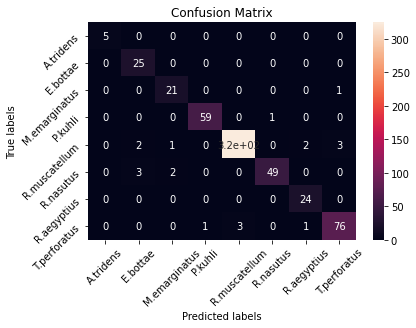

In [70]:
Y_pred = model.predict(X_test)
actual, predicted = generate_actual_predicted(Y_pred, X_test, Y_test)

##Confusion Matrix
from sklearn.metrics import confusion_matrix
actual_labeled = list()
predict_labeled = list()
for x,y in zip(actual,predicted):
    actual_labeled.append(getSpecies(x))
    predict_labeled.append(getSpecies(y))

labels = ['A.tridens','E.bottae','M.emarginatus','P.kuhli','R.muscatellum','R.nasutus', 'R.aegyptius', 'T.perforatus']
cm=confusion_matrix(actual_labeled,predict_labeled,labels=labels)
print(cm)

ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(labels,rotation=45); ax.yaxis.set_ticklabels(labels,rotation=45);

In [71]:
## Test accuracy
from sklearn.metrics import accuracy_score
print('accuracy', accuracy_score(actual, predicted))


accuracy 0.9668874172185431


In [72]:
## Precision, Recall, F1, Support
from sklearn.metrics import classification_report
print(classification_report(actual_labeled, predict_labeled,labels=labels))

               precision    recall  f1-score   support

    A.tridens       1.00      1.00      1.00         5
     E.bottae       0.83      1.00      0.91        25
M.emarginatus       0.88      0.95      0.91        22
      P.kuhli       0.98      0.98      0.98        60
R.muscatellum       0.99      0.98      0.98       333
    R.nasutus       0.98      0.91      0.94        54
  R.aegyptius       0.89      1.00      0.94        24
 T.perforatus       0.95      0.94      0.94        81

     accuracy                           0.97       604
    macro avg       0.94      0.97      0.95       604
 weighted avg       0.97      0.97      0.97       604



<h2>K-Fold Training and Evaluation</h2>

In [84]:
def build_current_model():
    inp = Input(shape=(112,170,3))
    lay = Convolution2D(filters=56,kernel_size=(7,7),strides=(2,2),padding='same')(inp)
    lay = BatchNormalization()(lay)
    lay = Activation('relu')(lay)
    lay = MaxPooling2D(pool_size=(2,2),strides=2,padding='same')(lay)
    lay = SpatialDropout2D(0.06)(lay)

    lay = Convolution2D(filters=72,kernel_size=(5,5),strides=(2,2),padding='same')(lay)
    lay = BatchNormalization()(lay)
    lay = Activation('relu')(lay)
    lay = AveragePooling2D(pool_size=(2,2),strides=2,padding='same')(lay)
    lay = SpatialDropout2D(0.06)(lay)

    lay = Convolution2D(filters=56,kernel_size=(3,3),strides=(1,1),padding='same')(lay)
    lay = BatchNormalization()(lay)
    lay = Activation('relu')(lay)
    lay = AveragePooling2D(pool_size=(2,2),strides=2,padding='same')(lay)
    lay = SpatialDropout2D(0.02)(lay)

    lay = Convolution2D(filters=72,kernel_size=(3,3),strides=(1,1),padding='same')(lay)
    lay = BatchNormalization()(lay)
    lay = Activation('relu')(lay)
    lay = AveragePooling2D(pool_size=(2,2),strides=2,padding='same')(lay)
    lay = SpatialDropout2D(0.02)(lay)

    lay = Flatten()(lay)

    lay = Dense(80)(lay)
    lay = BatchNormalization()(lay)
    lay = Activation('relu')(lay)
    lay = Dropout(0.15)(lay)

    lay = Dense(64)(lay)
    lay = BatchNormalization()(lay)
    lay = Activation('relu')(lay)
    lay = Dropout(0.15)(lay)

    lay = Dense(64)(lay)
    lay = BatchNormalization()(lay)
    lay = Activation('relu')(lay)
    lay = Dropout(0.15)(lay)

    x_out = Dense(8, name='output', activation='softmax')(lay)
    model = Model(inputs=inp, outputs=x_out)
    model.compile(
        optimizer=Adam(lr=0.003),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model


In [85]:
model = build_current_model()
model.summary()

Model: "model_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         [(None, 112, 170, 3)]     0         
_________________________________________________________________
conv2d_32 (Conv2D)           (None, 56, 85, 56)        8288      
_________________________________________________________________
batch_normalization_56 (Batc (None, 56, 85, 56)        224       
_________________________________________________________________
activation_56 (Activation)   (None, 56, 85, 56)        0         
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 28, 43, 56)        0         
_________________________________________________________________
spatial_dropout2d_32 (Spatia (None, 28, 43, 56)        0         
_________________________________________________________________
conv2d_33 (Conv2D)           (None, 14, 22, 72)        1008

In [77]:
from sklearn.metrics import precision_recall_fscore_support
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, auc, precision_recall_curve
from sklearn.metrics import confusion_matrix

all_base_precision = list()
all_base_recall = list()
all_macro_precision = list()
all_macro_recall = list()
all_f1 = list()
all_macro_f1 = list()


all_tpr = list()
all_fpr = list()
all_precision = list()
all_recall = list()
all_cm=list()
all_accuracy = list()


n_split=5
n_classes=8

y_all_labelled=[]
for i in range(len(Y_all)):
        y_all_labelled.append(np.argmax(Y_all[i]))
        
my_callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=20,verbose=1, mode='min',restore_best_weights=True)]
       
for train_index,test_index in StratifiedKFold(n_split, shuffle=True, random_state=123).split(X_all,y_all_labelled):  
    # use the index to generate training an testing sets
    x_train,x_test=X_all[train_index],X_all[test_index]
    y_train,y_test=Y_all[train_index],Y_all[test_index]
    
           
    # create and fit the model
    cv_model=build_current_model() # lr,dense,cnn
    history = cv_model.fit(x_train, y_train,
              batch_size=8,
              epochs=75,
              validation_split=0.1,
              verbose=2)
    
    #generate predictions
    y_pred = cv_model.predict(x_test)
    actual, predicted = generate_actual_predicted(y_pred, x_test, y_test)
    
    #calc metrics
    curr_base_prec, curr_base_rec, curr_f1, _ = precision_recall_fscore_support(actual, predicted)
    curr_macro_prec = precision_score(actual, predicted,average='macro')
    curr_macro_rec = recall_score(actual, predicted,average='macro')
    curr_macro_f1 = f1_score(actual, predicted,average='macro')
    
    
    actual_labeled = list()
    predict_labeled = list()
    for x,y in zip(actual,predicted):
        actual_labeled.append(getSpecies(x))
        predict_labeled.append(getSpecies(y))
        
    labels = ['A.tridens','E.bottae','M.emarginatus','P.kuhli','R.muscatellum','R.nasutus', 'R.aegyptius', 'T.perforatus']
    curr_cm=confusion_matrix(actual_labeled,predict_labeled,labels=labels)
    
    curr_fpr = [0] * n_classes
    curr_tpr = [0] * n_classes
    for i in range(n_classes):
        curr_fpr[i], curr_tpr[i], _ = roc_curve(y_test[:,i], y_pred[:,i])
        
    curr_prec = [0] * n_classes
    curr_rec = [0] * n_classes
    for i in range(n_classes):
        curr_prec[i], curr_rec[i], _ = precision_recall_curve(y_test[:,i], y_pred[:,i])

        
    curr_accuracy = accuracy_score(actual, predicted)
    
    #add to lists
    all_base_precision.append(curr_base_prec)
    all_base_recall.append(curr_base_rec)
    all_macro_precision.append(curr_macro_prec)
    all_macro_recall.append(curr_macro_rec)
    
    all_f1.append(curr_f1)
    all_macro_f1.append(curr_macro_f1)
    
    all_accuracy.append(curr_accuracy)

    
    all_fpr.append(curr_fpr)
    all_tpr.append(curr_tpr)
    all_precision.append(curr_prec)
    all_recall.append(curr_rec)
    all_cm.append(curr_cm)
    
    
    

Train on 2172 samples, validate on 242 samples
Epoch 1/100
2172/2172 - 3s - loss: 1.4437 - acc: 0.5368 - val_loss: 1.5183 - val_acc: 0.5579
Epoch 2/100
2172/2172 - 3s - loss: 1.2918 - acc: 0.5893 - val_loss: 1.1638 - val_acc: 0.6116
Epoch 3/100
2172/2172 - 2s - loss: 1.2148 - acc: 0.6123 - val_loss: 1.1223 - val_acc: 0.6198
Epoch 4/100
2172/2172 - 2s - loss: 1.1647 - acc: 0.6192 - val_loss: 1.1055 - val_acc: 0.6074
Epoch 5/100
2172/2172 - 2s - loss: 1.1081 - acc: 0.6271 - val_loss: 1.0729 - val_acc: 0.6116
Epoch 6/100
2172/2172 - 3s - loss: 0.9651 - acc: 0.6731 - val_loss: 1.0529 - val_acc: 0.7025
Epoch 7/100
2172/2172 - 2s - loss: 0.9477 - acc: 0.6800 - val_loss: 0.7998 - val_acc: 0.7107
Epoch 8/100
2172/2172 - 2s - loss: 0.8799 - acc: 0.7049 - val_loss: 1.0749 - val_acc: 0.6322
Epoch 9/100
2172/2172 - 2s - loss: 0.8423 - acc: 0.7159 - val_loss: 0.7658 - val_acc: 0.7273
Epoch 10/100
2172/2172 - 2s - loss: 0.7702 - acc: 0.7426 - val_loss: 0.6579 - val_acc: 0.7769
Epoch 11/100
2172/2172

Epoch 88/100
2172/2172 - 2s - loss: 0.0752 - acc: 0.9788 - val_loss: 0.1353 - val_acc: 0.9545
Epoch 89/100
2172/2172 - 2s - loss: 0.1589 - acc: 0.9558 - val_loss: 0.0554 - val_acc: 0.9793
Epoch 90/100
2172/2172 - 2s - loss: 0.0962 - acc: 0.9742 - val_loss: 0.0464 - val_acc: 0.9876
Epoch 91/100
2172/2172 - 2s - loss: 0.0959 - acc: 0.9715 - val_loss: 0.0597 - val_acc: 0.9876
Epoch 92/100
2172/2172 - 2s - loss: 0.0721 - acc: 0.9747 - val_loss: 0.0692 - val_acc: 0.9669
Epoch 93/100
2172/2172 - 2s - loss: 0.0749 - acc: 0.9765 - val_loss: 0.0735 - val_acc: 0.9752
Epoch 94/100
2172/2172 - 2s - loss: 0.0947 - acc: 0.9733 - val_loss: 0.0910 - val_acc: 0.9587
Epoch 95/100
2172/2172 - 2s - loss: 0.0739 - acc: 0.9774 - val_loss: 0.1253 - val_acc: 0.9628
Epoch 96/100
2172/2172 - 2s - loss: 0.0832 - acc: 0.9751 - val_loss: 0.1323 - val_acc: 0.9628
Epoch 97/100
2172/2172 - 2s - loss: 0.0975 - acc: 0.9669 - val_loss: 0.1054 - val_acc: 0.9711
Epoch 98/100
2172/2172 - 2s - loss: 0.0567 - acc: 0.9825 - v

Epoch 75/100
2172/2172 - 2s - loss: 0.1173 - acc: 0.9669 - val_loss: 0.1442 - val_acc: 0.9628
Epoch 76/100
2172/2172 - 2s - loss: 0.0940 - acc: 0.9779 - val_loss: 0.1797 - val_acc: 0.9545
Epoch 77/100
2172/2172 - 2s - loss: 0.0527 - acc: 0.9853 - val_loss: 0.1408 - val_acc: 0.9711
Epoch 78/100
2172/2172 - 2s - loss: 0.1025 - acc: 0.9724 - val_loss: 0.0988 - val_acc: 0.9711
Epoch 79/100
2172/2172 - 2s - loss: 0.0845 - acc: 0.9761 - val_loss: 0.1320 - val_acc: 0.9711
Epoch 80/100
Restoring model weights from the end of the best epoch.
2172/2172 - 2s - loss: 0.0620 - acc: 0.9802 - val_loss: 0.1741 - val_acc: 0.9711
Epoch 00080: early stopping
Train on 2172 samples, validate on 242 samples
Epoch 1/100
2172/2172 - 3s - loss: 1.4938 - acc: 0.5258 - val_loss: 1.4351 - val_acc: 0.4256
Epoch 2/100
2172/2172 - 2s - loss: 1.3420 - acc: 0.5714 - val_loss: 1.2613 - val_acc: 0.5579
Epoch 3/100
2172/2172 - 2s - loss: 1.2576 - acc: 0.5889 - val_loss: 1.1959 - val_acc: 0.5909
Epoch 4/100
2172/2172 - 2s

Epoch 81/100
2172/2172 - 2s - loss: 0.0559 - acc: 0.9820 - val_loss: 0.1231 - val_acc: 0.9793
Epoch 82/100
2172/2172 - 2s - loss: 0.0832 - acc: 0.9793 - val_loss: 0.0702 - val_acc: 0.9917
Epoch 83/100
2172/2172 - 2s - loss: 0.1157 - acc: 0.9715 - val_loss: 0.1333 - val_acc: 0.9711
Epoch 84/100
2172/2172 - 2s - loss: 0.0768 - acc: 0.9761 - val_loss: 0.2739 - val_acc: 0.9339
Epoch 85/100
2172/2172 - 2s - loss: 0.0796 - acc: 0.9770 - val_loss: 0.1845 - val_acc: 0.9628
Epoch 86/100
2172/2172 - 2s - loss: 0.0853 - acc: 0.9784 - val_loss: 0.1563 - val_acc: 0.9669
Epoch 87/100
2172/2172 - 2s - loss: 0.1288 - acc: 0.9669 - val_loss: 0.2706 - val_acc: 0.9339
Epoch 88/100
2172/2172 - 2s - loss: 0.0721 - acc: 0.9820 - val_loss: 0.0979 - val_acc: 0.9752
Epoch 89/100
2172/2172 - 2s - loss: 0.1121 - acc: 0.9678 - val_loss: 0.2897 - val_acc: 0.9380
Epoch 90/100
2172/2172 - 2s - loss: 0.0605 - acc: 0.9816 - val_loss: 0.0927 - val_acc: 0.9752
Epoch 91/100
2172/2172 - 2s - loss: 0.0478 - acc: 0.9839 - v

Train on 2173 samples, validate on 242 samples
Epoch 1/100
2173/2173 - 3s - loss: 1.5435 - acc: 0.4988 - val_loss: 1.4403 - val_acc: 0.4711
Epoch 2/100
2173/2173 - 2s - loss: 1.3053 - acc: 0.5757 - val_loss: 1.3660 - val_acc: 0.5620
Epoch 3/100
2173/2173 - 2s - loss: 1.2464 - acc: 0.5886 - val_loss: 1.1401 - val_acc: 0.5992
Epoch 4/100
2173/2173 - 2s - loss: 1.1420 - acc: 0.6203 - val_loss: 1.0807 - val_acc: 0.6240
Epoch 5/100
2173/2173 - 2s - loss: 1.0232 - acc: 0.6521 - val_loss: 1.1103 - val_acc: 0.6777
Epoch 6/100
2173/2173 - 2s - loss: 0.9657 - acc: 0.6608 - val_loss: 0.8663 - val_acc: 0.7066
Epoch 7/100
2173/2173 - 2s - loss: 0.9232 - acc: 0.6852 - val_loss: 0.8255 - val_acc: 0.7314
Epoch 8/100
2173/2173 - 2s - loss: 0.8798 - acc: 0.6903 - val_loss: 0.8048 - val_acc: 0.7521
Epoch 9/100
2173/2173 - 2s - loss: 0.8189 - acc: 0.7105 - val_loss: 0.7196 - val_acc: 0.7603
Epoch 10/100
2173/2173 - 2s - loss: 0.7661 - acc: 0.7533 - val_loss: 0.5570 - val_acc: 0.8140
Epoch 11/100
2173/2173

Epoch 78/100
2173/2173 - 2s - loss: 0.0734 - acc: 0.9765 - val_loss: 0.1503 - val_acc: 0.9628
Epoch 79/100
2173/2173 - 2s - loss: 0.0799 - acc: 0.9765 - val_loss: 0.2298 - val_acc: 0.9215
Epoch 80/100
2173/2173 - 2s - loss: 0.1004 - acc: 0.9719 - val_loss: 0.0894 - val_acc: 0.9628
Epoch 81/100
2173/2173 - 2s - loss: 0.1233 - acc: 0.9673 - val_loss: 0.1021 - val_acc: 0.9628
Epoch 82/100
2173/2173 - 2s - loss: 0.1223 - acc: 0.9604 - val_loss: 0.1372 - val_acc: 0.9628
Epoch 83/100
2173/2173 - 2s - loss: 0.1262 - acc: 0.9659 - val_loss: 0.7653 - val_acc: 0.7603
Epoch 84/100
2173/2173 - 2s - loss: 0.1198 - acc: 0.9682 - val_loss: 0.1656 - val_acc: 0.9628
Epoch 85/100
2173/2173 - 2s - loss: 0.0577 - acc: 0.9830 - val_loss: 0.1082 - val_acc: 0.9628
Epoch 86/100
2173/2173 - 2s - loss: 0.0981 - acc: 0.9765 - val_loss: 0.1816 - val_acc: 0.9587
Epoch 87/100
2173/2173 - 2s - loss: 0.0877 - acc: 0.9788 - val_loss: 0.1113 - val_acc: 0.9711
Epoch 88/100
2173/2173 - 2s - loss: 0.0957 - acc: 0.9742 - v

Epoch 64/100
2173/2173 - 2s - loss: 0.1289 - acc: 0.9692 - val_loss: 0.1292 - val_acc: 0.9545
Epoch 65/100
2173/2173 - 2s - loss: 0.1329 - acc: 0.9600 - val_loss: 0.1052 - val_acc: 0.9628
Epoch 66/100
2173/2173 - 2s - loss: 0.0809 - acc: 0.9751 - val_loss: 0.1331 - val_acc: 0.9711
Epoch 67/100
2173/2173 - 2s - loss: 0.0966 - acc: 0.9719 - val_loss: 0.1787 - val_acc: 0.9504
Epoch 68/100
2173/2173 - 2s - loss: 0.1067 - acc: 0.9724 - val_loss: 0.1360 - val_acc: 0.9545
Epoch 69/100
2173/2173 - 2s - loss: 0.0993 - acc: 0.9701 - val_loss: 0.1414 - val_acc: 0.9463
Epoch 70/100
2173/2173 - 2s - loss: 0.1056 - acc: 0.9669 - val_loss: 0.1665 - val_acc: 0.9463
Epoch 71/100
2173/2173 - 2s - loss: 0.0991 - acc: 0.9701 - val_loss: 0.1285 - val_acc: 0.9628
Epoch 72/100
2173/2173 - 2s - loss: 0.0838 - acc: 0.9710 - val_loss: 0.3350 - val_acc: 0.9091
Epoch 73/100
2173/2173 - 2s - loss: 0.0961 - acc: 0.9673 - val_loss: 0.2484 - val_acc: 0.9256
Epoch 74/100
2173/2173 - 2s - loss: 0.1421 - acc: 0.9636 - v

In [78]:
print('precision mean by class', np.array(all_base_precision).mean(axis=0))
print('precision sdev by class', np.array(all_base_precision).std(axis=0))

print('macro precision mean', np.array(all_macro_precision).mean())
print('macro precision sdev', np.array(all_macro_precision).std())


print('recall mean', np.array(all_base_recall).mean(axis=0))
print('recall sdev', np.array(all_base_recall).std(axis=0))

print('macro recall mean', np.array(all_macro_recall).mean())
print('macro recall sdev', np.array(all_macro_recall).std())

print('f1 mean', np.array(all_f1).mean(axis=0))
print('f1 sdev', np.array(all_f1).std(axis=0))

print('macro f1 mean', np.array(all_macro_f1).mean())
print('macro f1 sdev', np.array(all_macro_f1).std())

print('accuracy mean', np.array(all_accuracy).mean())
print('accuracy sdev', np.array(all_accuracy).std())



precision mean by class [1.         0.90629345 0.93520898 0.9303372  0.9767616  0.96180169
 0.83159907 0.93659826]
precision sdev by class [0.         0.05173373 0.01815025 0.0454683  0.00849991 0.01113832
 0.05408764 0.0402963 ]
macro precision mean 0.9348250319218359
macro precision sdev 0.010883292256298338
recall mean [0.88       0.911      0.76758893 0.94649718 0.97957958 0.93291405
 0.87566667 0.96271605]
recall sdev [0.16       0.018      0.06108734 0.02865671 0.01207192 0.03862667
 0.05941006 0.01767918]
macro recall mean 0.9069953062122653
macro recall sdev 0.022067241606826243
f1 mean [0.92777778 0.9079819  0.84182011 0.93755689 0.97809215 0.94670311
 0.85085307 0.94897037]
f1 sdev [0.09875772 0.02949493 0.0385016  0.02695475 0.00583691 0.02077428
 0.03662111 0.02324759]
macro f1 mean 0.9174694229839128
macro f1 sdev 0.01857268192597333
accuracy mean 0.9542700405258475
accuracy sdev 0.009197275369660706


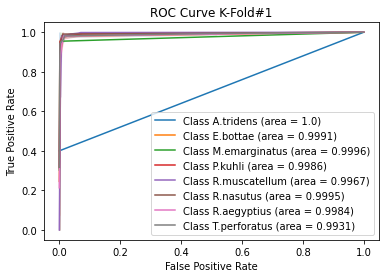

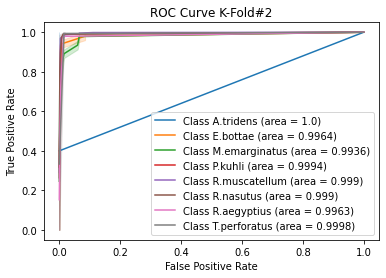

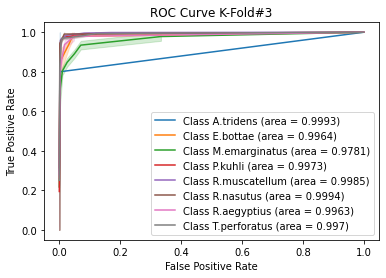

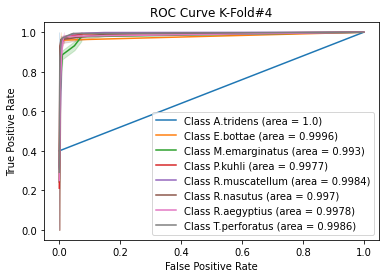

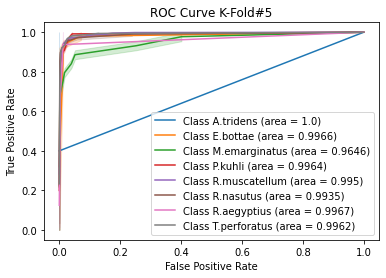

In [79]:
# Plot all K-Fold ROC curves

for i in range(n_split):
    _, axs = plt.subplots(ncols=1)
    axs.set(xlabel='False Positive Rate',ylabel='True Positive Rate', title='ROC Curve K-Fold#'+str(i+1))
    for j in range(n_classes):
        auc_val = auc(all_fpr[i][j], all_tpr[i][j])
        auc_val = np.around(auc_val,4)
        sns.lineplot(x=all_fpr[i][j],y=all_tpr[i][j],ax=axs, label='Class '+ getSpecies(j) +' (area = ' + str(auc_val) + ')', legend='brief')
        

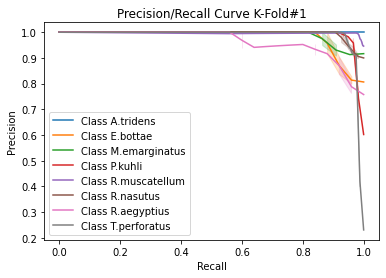

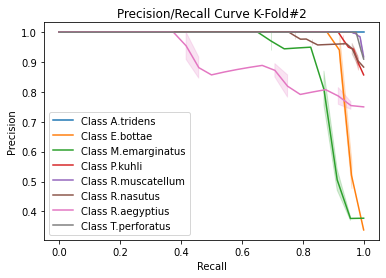

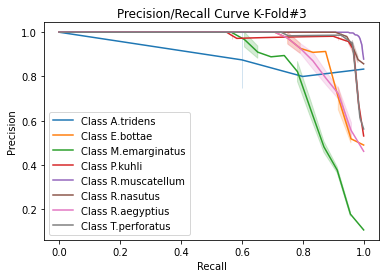

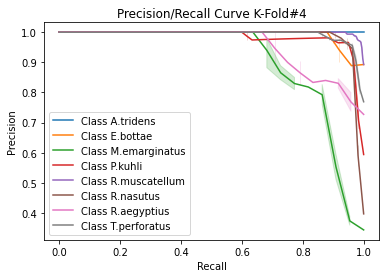

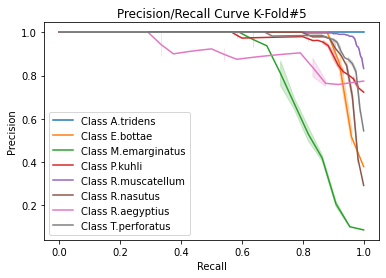

In [80]:
#Plot all K-Fold Precision/Recall curves
for i in range(n_split):
    _, axs = plt.subplots(ncols=1)
    axs.set(xlabel='Recall',ylabel='Precision', title='Precision/Recall Curve K-Fold#'+str(i+1))
    for j in range(n_classes):
        sns.lineplot(x=all_recall[i][j],y=all_precision[i][j],ax=axs, label='Class '+ getSpecies(j), legend='brief')

Confusion Matrix K-Fold #1

[[  5   0   0   0   0   0   0   0]
 [  0  23   0   0   1   1   0   0]
 [  0   0  19   0   1   0   0   2]
 [  0   1   0  56   1   1   0   0]
 [  0   1   0   0 328   0   1   3]
 [  0   2   0   0   0  51   1   0]
 [  0   0   0   1   0   0  23   1]
 [  0   0   1   0   3   0   0  77]]


Confusion Matrix K-Fold #2

[[  5   0   0   0   0   0   0   0]
 [  0  23   0   0   1   1   0   0]
 [  0   0  18   0   5   0   0   0]
 [  0   0   1  56   1   1   0   1]
 [  0   1   0   0 330   0   2   0]
 [  0   2   0   2   0  47   2   0]
 [  0   0   0   0   3   0  20   1]
 [  0   0   0   0   0   0   1  80]]


Confusion Matrix K-Fold #3

[[  3   0   0   0   0   0   2   0]
 [  0  21   0   1   1   1   0   0]
 [  0   0  18   5   0   0   0   0]
 [  0   0   0  59   0   0   0   1]
 [  0   1   2   2 323   0   1   4]
 [  0   2   0   0   0  52   0   0]
 [  0   0   0   1   2   0  21   0]
 [  0   0   0   0   0   0   2  79]]


Confusion Matrix K-Fold #4

[[  5   0   0   0   0   0   0   0]
 [  

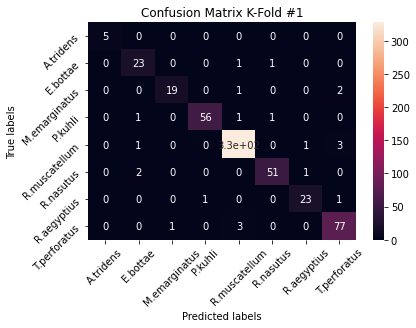

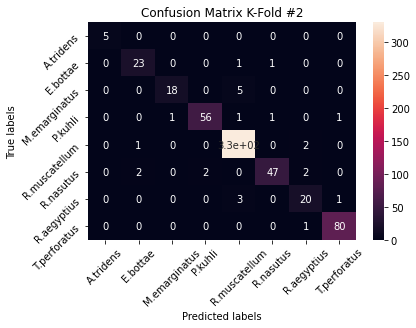

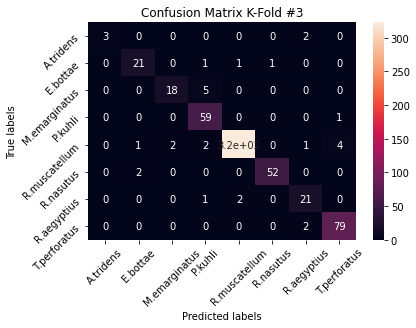

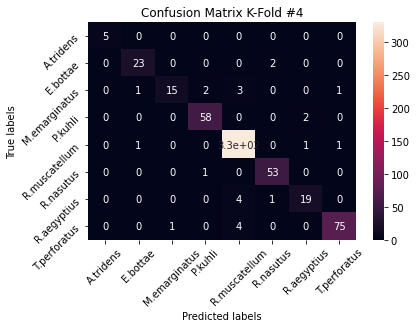

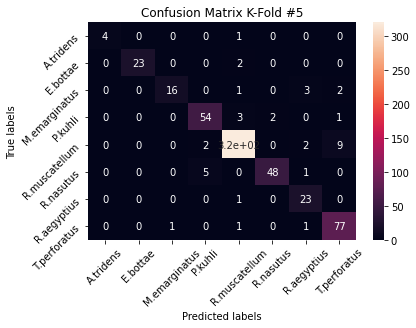

In [81]:
## Plot all K-Fold confusion matrices
import numpy as np
import matplotlib.pylab as pl
import matplotlib.gridspec as gridspec
from matplotlib import pyplot as plt

# Create 1X 5 sub plots
# gs = gridspec.GridSpec(1,n_split)
figs=[]
for i in range(n_split):
    figs.append(plt.figure())
    
for i in range(n_split):
    print('Confusion Matrix K-Fold #'+ str(i+1)+"\n")
    print(all_cm[i])
    print("\n")
    
    ax=figs[i].add_subplot()
    sns.heatmap(all_cm[i], annot=True, ax = ax); #annot=True to annotate cells

    
    # labels, title and ticks
    ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
    ax.set_title('Confusion Matrix K-Fold #'+ str(i+1)); 
    ax.xaxis.set_ticklabels(labels,rotation=45); ax.yaxis.set_ticklabels(labels,rotation=45);

sum of all confuion matrices
 [[  22    0    0    0    1    0    2    0]
 [   0  113    0    1    5    5    0    0]
 [   0    1   86    7   10    0    3    5]
 [   0    1    1  283    5    4    2    3]
 [   0    4    2    4 1631    0    7   17]
 [   0    6    0    8    0  251    4    0]
 [   0    0    0    2   10    1  106    2]
 [   0    0    3    0    8    0    4  388]]

average of all confuion matrices
 [[  4   0   0   0   0   0   0   0]
 [  0  22   0   0   1   1   0   0]
 [  0   0  17   1   2   0   0   1]
 [  0   0   0  56   1   0   0   0]
 [  0   0   0   0 326   0   1   3]
 [  0   1   0   1   0  50   0   0]
 [  0   0   0   0   2   0  21   0]
 [  0   0   0   0   1   0   0  77]]


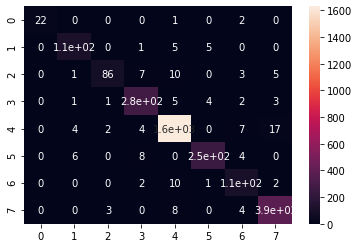

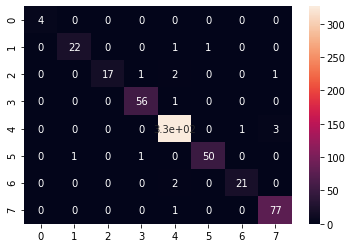

In [82]:
## plot macro cm

sum_all_cm=np.zeros((n_classes,n_classes)).astype('int64')
for i in range(n_split):
    sum_all_cm+=all_cm[i]
    
    
#plot 
figs=[]
for i in range(2):
    figs.append(plt.figure())
       
print("sum of all confuion matrices\n",sum_all_cm)
ax=figs[0].add_subplot()
sns.heatmap(sum_all_cm, annot=True, ax = ax);

avg_all_cm=np.divide(sum_all_cm,n_split).astype('int64')
print("\naverage of all confuion matrices\n",avg_all_cm)
ax=figs[1].add_subplot()
sns.heatmap(avg_all_cm, annot=True, ax = ax);

[[0.88 0.   0.   0.   0.04 0.   0.08 0.  ]
 [0.   0.91 0.   0.01 0.04 0.04 0.   0.  ]
 [0.   0.01 0.77 0.06 0.09 0.   0.03 0.04]
 [0.   0.   0.   0.95 0.02 0.01 0.01 0.01]
 [0.   0.   0.   0.   0.98 0.   0.   0.01]
 [0.   0.02 0.   0.03 0.   0.93 0.01 0.  ]
 [0.   0.   0.   0.02 0.08 0.01 0.88 0.02]
 [0.   0.   0.01 0.   0.02 0.   0.01 0.96]]


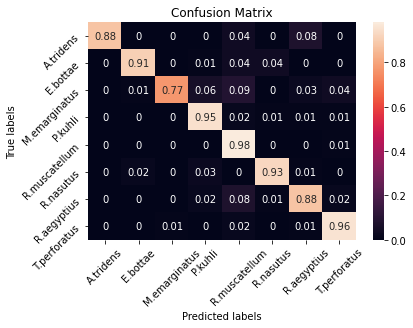

In [83]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


cm= sum_all_cm/ sum_all_cm.astype(np.float).sum(axis=1,keepdims = True)
cm = (np.around(cm,2))
print(cm)


labels = ['A.tridens','E.bottae','M.emarginatus','P.kuhli','R.muscatellum','R.nasutus', 'R.aegyptius', 'T.perforatus']


ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(labels,rotation=45); ax.yaxis.set_ticklabels(labels,rotation=45);

<h2>Storing/Loading history and model to file</h2>

In [23]:
#Store History
hist_df = pd.DataFrame(history.history) 
hist_json_file = 'Model2-P-bats.json' 
with open(hist_json_file, mode='w') as f:
    hist_df.to_json(f)

In [25]:
#Load History 
history_info = pd.read_json('Model2-P-bats.json')

In [26]:
##Save Model
model.save('Model2-P-bats_trained.model') #Save the model

In [27]:
## Load Model
model = tf.keras.models.load_model('Model2V2-bats_trained.model') #Re load model

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
